In [ ]:
'''
Problem Statement:
    
Alpha-synuclein (asyn) is a highly abundant protein present in the neurons and is produced by SNCA gene. It clusters into aggregates when you age and in some neurodegenerative diseases such as Parkinson’s and dementia. 
These aggregates appear as spots in an image, also called the phenotype.  A high-content image-based experiment was done to identify compounds that clear these aggregates. For this purpose, 
we used an internally compiled dataset of 2900 compounds that were plated in 384-well plates at 5 concentrations resulting in 15,000 images. Each plate has 32 controls: 16 neutral control wells and 16 positive controls
and 64 compounds at 5 concentrations. 2900 compounds are distributed in 42, 384 well plates. Neutral control has plenty of spots in the image and positive control has cleared the spots.
Neutral control is assigned class 0 and positive control is assigned class 1.

The goal is to apply a combination of unsupervised and supervised machine learning models to identify hits.

Model Targets and Features:

Target Variable: inhibitory activity of the compound
Feature set: 229 image-based features belonging to different categories
    

Goals and Success Metrics:
    
1) Extract the most important features from the reference controls
2) Predict with reasonable accuracy the hit-rate and inhibitory activity of the compounds that are expected to fall between 0 and 1
3) Hits to follow up for a 12 concentration experiment

Risks and Limitations:
    
This experiment is done with a brain cancer cell line and the compounds identified in this experiment could be toxic to neurons.
Develop machine learning models based on the reference controls used in the experiment and predict the activity of test compounds.

Getting the datasets ready:
'''

In [61]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [62]:
# Ensures that plots appear inside the notebook.
# Not necessary in some versions of Jupyter Notebook / JupyterLab.
%matplotlib inline

In [63]:
asyn_df = pd.read_csv("C:/Users/lakella/Desktop/GA/Lessons/projects/finalproject/part1/data/cntrls_cmpds_Combined5pt.csv")

In [64]:
# Get the number of rows and columns
asyn_df.shape

(18051, 229)

In [65]:
# Select first n rows, 5 by default
asyn_df.head()

,PlateName,WellType,class,WellName,Row,Column,Nuclei - Number of Objects,Nuclei - Int GFP Median - Median per Well,Nuclei - Int GFP CV [%] - Median per Well,Nuclei - Int GFP Quantile 50% - Median per Well,...,Spots - Spot Area [px²] - Median per Well,Spots - Region Intensity - Median per Well,Spots - Spot to Region Intensity - Median per Well,Spots - Spot Morphology Area [µm²] - Median per Well,Spots - Spot Morphology Roundness - Median per Well,Spots - Spot Morphology Width [µm] - Median per Well,Spots - Spot Morphology Length [µm] - Median per Well,Spots - Spot Morphology Ratio Width to Length - Median per Well,Spots/Cell,Spot Area Occupancy
0,PEP00001660,Inhibitor,1,A1,1,1,4219,1899.0,28.859954,1899.0,...,19.0,2547.198381,1.587845,6.081863,0.863841,1.600245,3.200490,0.565685,0.749941,6.919831
1,PEP00001660,Neutral,0,A2,1,2,4033,2228.0,53.881622,2228.0,...,22.0,2862.324933,1.693837,7.042157,0.903940,1.600245,3.298990,0.632456,3.906769,8.032585
2,PEP00001660,Compound,Untagged,A3,1,3,4461,1661.0,40.472752,1661.0,...,19.0,2132.899081,1.847260,6.081863,0.910599,1.600245,3.046776,0.632456,2.221475,7.815285
3,PEP00001660,Compound,Untagged,A4,1,4,4152,1841.0,48.409016,1841.0,...,20.0,2385.418157,1.780084,6.401961,0.912571,1.600245,3.046776,0.632456,3.112235,7.764460
4,PEP00001660,Compound,Untagged,A5,1,5,3949,1913.0,51.546422,1913.0,...,20.0,2536.005556,1.754049,6.401961,0.912571,1.600245,3.046776,0.632456,3.433021,7.488280


In [66]:
# See the types of the columns
asyn_df.dtypes

PlateName                                                           object
WellType                                                            object
class                                                               object
WellName                                                            object
Row                                                                  int64
                                                                    ...   
Spots - Spot Morphology Width [µm] - Median per Well               float64
Spots - Spot Morphology Length [µm] - Median per Well              float64
Spots - Spot Morphology Ratio Width to Length - Median per Well    float64
Spots/Cell                                                         float64
Spot Area Occupancy                                                float64
Length: 229, dtype: object

In [67]:
# View row index
asyn_df.index

RangeIndex(start=0, stop=18051, step=1)

In [68]:
# View column index
asyn_df.columns

Index(['PlateName', 'WellType', 'class', 'WellName', 'Row', 'Column',
       'Nuclei - Number of Objects',
       'Nuclei - Int GFP Median - Median per Well',
       'Nuclei - Int GFP CV [%] - Median per Well',
       'Nuclei - Int GFP Quantile 50% - Median per Well',
       ...
       'Spots - Spot Area [px²] - Median per Well',
       'Spots - Region Intensity - Median per Well',
       'Spots - Spot to Region Intensity - Median per Well',
       'Spots - Spot Morphology Area [µm²] - Median per Well',
       'Spots - Spot Morphology Roundness - Median per Well',
       'Spots - Spot Morphology Width [µm] - Median per Well',
       'Spots - Spot Morphology Length [µm] - Median per Well',
       'Spots - Spot Morphology Ratio Width to Length - Median per Well',
       'Spots/Cell', 'Spot Area Occupancy'],
      dtype='object', length=229)

In [69]:
# Get a concise summary of DataFrame contents "from the computer's perspective"
asyn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18051 entries, 0 to 18050
Columns: 229 entries, PlateName to Spot Area Occupancy
dtypes: float64(221), int64(4), object(4)
memory usage: 31.5+ MB


In [70]:
# Get a concise summary of DataFrame contents from a data modeler's perspective
asyn_df.describe()

,Row,Column,Nuclei - Number of Objects,Nuclei - Int GFP Median - Median per Well,Nuclei - Int GFP CV [%] - Median per Well,Nuclei - Int GFP Quantile 50% - Median per Well,Nuclei - Int GFP Contrast - Median per Well,Nuclei - Nucleus Morphology Area [µm²] - Median per Well,Nuclei - Nucleus Morphology Roundness - Median per Well,Nuclei - Nucleus Morphology Width [µm] - Median per Well,...,Spots - Spot Area [px²] - Median per Well,Spots - Region Intensity - Median per Well,Spots - Spot to Region Intensity - Median per Well,Spots - Spot Morphology Area [µm²] - Median per Well,Spots - Spot Morphology Roundness - Median per Well,Spots - Spot Morphology Width [µm] - Median per Well,Spots - Spot Morphology Length [µm] - Median per Well,Spots - Spot Morphology Ratio Width to Length - Median per Well,Spots/Cell,Spot Area Occupancy
count,18051.000000,18051.000000,18051.000000,18037.000000,18037.000000,18037.000000,18037.000000,18037.000000,18037.000000,18037.000000,...,17776.000000,17776.000000,17776.000000,17776.000000,17776.000000,17776.000000,17776.000000,17776.000000,18037.000000,17776.000000
mean,8.513656,12.319761,3943.390560,1464.306481,42.088419,1464.306481,0.749698,112.973018,0.862939,8.213316,...,19.114761,1982.536290,1.888340,6.154348,0.904530,1.612208,3.043834,0.630447,2.264878,7.317590
std,4.607758,6.937067,702.208939,409.294876,8.053861,409.294876,0.122011,13.247908,0.020662,0.523244,...,2.014908,450.093000,0.310381,0.612391,0.015731,0.072756,0.211542,0.030869,0.987117,1.122905
min,1.000000,1.000000,0.000000,137.500000,7.744810,137.500000,0.010660,35.530883,0.471870,4.793298,...,4.000000,149.018706,0.848702,1.280392,0.681379,0.565772,0.800123,0.332932,0.000000,0.529577
25%,5.000000,6.000000,3942.000000,1338.000000,39.204524,1338.000000,0.756324,111.074022,0.853886,8.159681,...,18.000000,1820.530161,1.772816,5.821061,0.902395,1.600245,3.046776,0.632456,1.898258,7.019498
50%,9.000000,12.000000,4130.000000,1576.000000,44.848202,1576.000000,0.783782,112.997058,0.859145,8.159681,...,20.000000,2092.377409,1.825958,6.401961,0.903940,1.600245,3.046776,0.632456,2.665023,7.482870
75%,13.000000,18.000000,4282.000000,1726.000000,47.103439,1726.000000,0.800259,115.235296,0.866848,8.237766,...,20.000000,2275.228429,1.904511,6.401961,0.910599,1.600245,3.046776,0.632456,2.948844,7.755819
max,16.000000,24.000000,5477.000000,2529.500000,69.251879,2529.500000,0.864532,241.353926,0.985124,12.801961,...,46.000000,3178.732083,7.767369,14.564461,1.152993,2.530210,6.302395,1.414214,4.843028,27.632894


In [71]:
# Get summary information for non-numeric columns
asyn_df.describe(include=object)

,PlateName,WellType,class,WellName
count,18051,18051,18051,18051
unique,43,3,3,384
top,PEP00001963,Compound,Untagged,N1
freq,1119,15026,15026,52


In [72]:
# Get the means of the numeric columns
asyn_df.mean()

Row                                                                   8.513656
Column                                                               12.319761
Nuclei - Number of Objects                                         3943.390560
Nuclei - Int GFP Median - Median per Well                          1464.306481
Nuclei - Int GFP CV [%] - Median per Well                            42.088419
                                                                      ...     
Spots - Spot Morphology Width [µm] - Median per Well                  1.612208
Spots - Spot Morphology Length [µm] - Median per Well                 3.043834
Spots - Spot Morphology Ratio Width to Length - Median per Well       0.630447
Spots/Cell                                                            2.264878
Spot Area Occupancy                                                   7.317590
Length: 225, dtype: float64

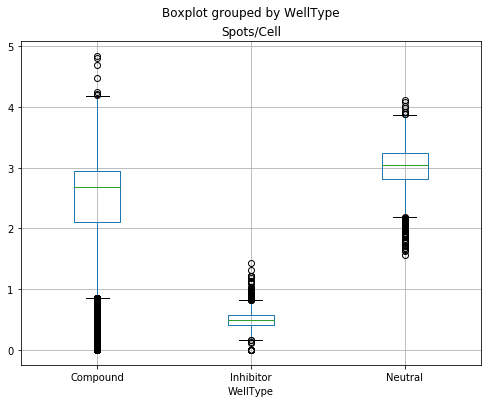

In [73]:
# Box plot of Well Type grouped by Plate Name, using `boxplot` convenience method
asyn_df.boxplot(column="Spots/Cell", by="WellType", figsize=(8,6))

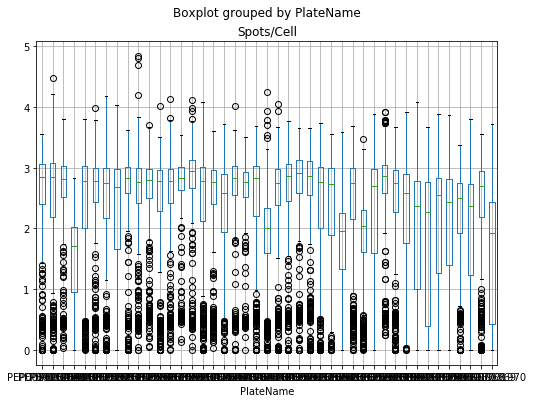

In [74]:
# Box plot of Well Type grouped by Plate Name, using `boxplot` convenience method
asyn_df.boxplot(column="Spots/Cell", by="PlateName", figsize=(8,6))